In [6]:
import os

/home/mlyko


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import cityscapes_labels
import utils
from generator import *

from models import *
from keras import losses, metrics, optimizers
from metrics import precision, dice_coef


ImportError: No module named cityscapes_labels

In [4]:
#target_height, target_width = 360, 480
#target_height, target_width = 360, 648
target_size = 256, 512

import config


labels = cityscapes_labels.labels
n_classes = len(labels)
batch_size = 2
epochs = 10

dataset_path = config.data_path()

# segnet
#model = MobileUNetWarp(target_size, n_classes)
model = ICNetWarp1(target_size, n_classes)
model.compile()

-- Optimizer: Adam
('---- Params: ', {'lr': 0.0021, 'decay': 0.003})
('---- For Training: ', True)


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_new (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
data_sub2 (Lambda)              (None, 128, 256, 3)  0           data_new[0][0]                   
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 64, 128, 32)  896         data_sub2[0][0]                  
__________________________________________________________________________________________________
conv1_1_3x3_s2_bn (BatchNormali (None, 64, 128, 32)  128         conv1_1_3x3_s2[0][0]             
__________________________________________________________________________________________________
conv1_2_3x

In [7]:
!ls ../../weights/city/deb/MobileUNetWarp/20/

ls: cannot access '../../weights/city/deb/MobileUNetWarp/20/warp1_add': No such file or directory


In [9]:
!ls checkpoint/city/deb/MobileUNetWarp/20/

b5_sp04+b18+adding_save_epoch.h5	 warp_1_b5_up1bn_save_epoch.h5
b5_sp04+b18+bn_up5+adding_save_epoch.h5  warp_1_b5_up5+4+3+2+1bn_save_epoch.h5
b5_sp04+b18+up2_adding_save_epoch.h5	 warp_1_b5_up5+4+3+2bn_save_epoch.h5
mobile_unet_warp_1_save_epoch.h5	 warp_1_b5_up5+4bn_save_epoch.h5
warp_0_b5_res_save_epoch.h5		 warp_1_b5_up5bn_save_epoch.h5
warp11_b5_save_epoch.h5			 warp_1_b6_s0.3_trbn_save_epoch.h5
warp11_rev_b5_save_epoch.h5		 warp1_rev_save_epoch.h5
warp135_b5_save_epoch.h5		 warp1_save_epoch.h5
warp13_b5_save_epoch.h5			 warp3_b5_save_epoch.h5
warp15_b5_save_epoch.h5			 warp5_b5_save_epoch.h5
warp_1_b5_resize_save_epoch.h5		 warp5_rev_b5_save_epoch.h5
warp_1_b5_s0.3_trbn_save_epoch.h5	 warp6_b5_save_epoch.h5
warp_1_b5_trbn_save_epoch.h5


In [5]:
#model.k.load_weights('/home/mlyko/weights/city/deb/MobileUNetWarp/20/warp1_add.h5')
model.k.load_weights('/home/mlyko/weights/city/rel/ICNetWarp1/2207:43b16_lr=0.000900_dec=0.050000.h5')


In [6]:
# test visualize
import keras.backend as K

datagen = CityscapesFlowGeneratorForICNet(dataset_path, prev_skip=1)

('-- Cityscapes Previous skip', 1)
('-- Optical flow type', 'dis')
--- flip False
/home/mlyko/data/cityscapes/
Cityscapes: train 2975 files
Cityscapes: shuffling dataset
Cityscapes: val 500 files
Cityscapes: shuffling dataset
Cityscapes: test 1525 files
Cityscapes: shuffling dataset
training samples 2975, validating samples 500, test samples 1525


In [7]:
def layer_to_visualize(img_to_visualize, model, layer, feed=[]):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + X)

    convolutions = convout1_f(img_to_visualize)    
    convolutions = np.squeeze(convolutions)
    convolutions=np.moveaxis(convolutions, 2, 0)
    print ('Shape of conv:', convolutions.shape)
    
    filters = convolutions.shape[0]
    print("convs", filters)
    n = int(np.ceil(np.sqrt(filters)))
        
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(32,32))
#    ax = fig.add_subplot(1,1)    
    #plt.imshow(convolutions[0], cmap='gray')
    #  flow_bgr=datagen.flow_to_bgr(convolutions, convolutions.shape[1:])
    
    #return
    
    for i in range(filters):
        ax = fig.add_subplot(n,n,i+1)
     #   flow_bgr=datagen.flow_to_bgr(convolutions, convolutions.shape[1:])
        ax.imshow(convolutions[i], cmap='gray')

('Shape of conv:', (2, 16, 32))
('convs', 2)


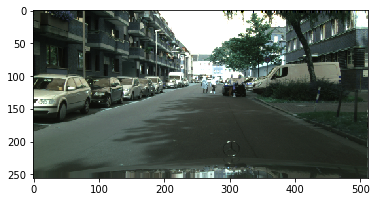

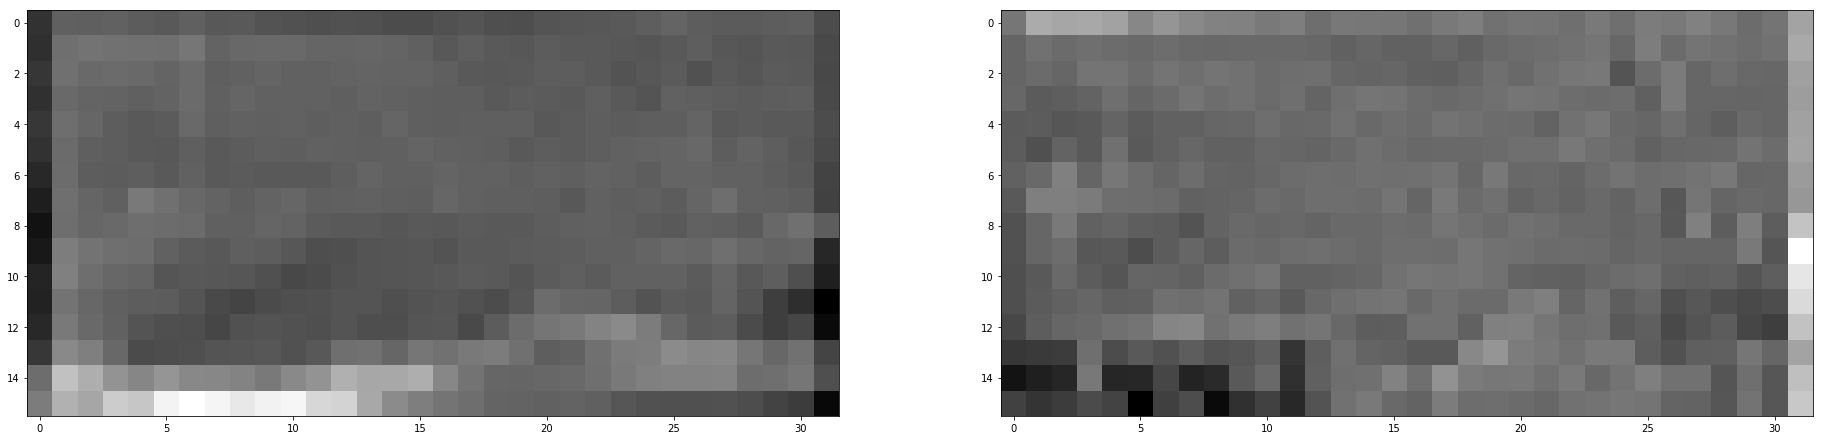

In [16]:
x = 0

for imgBatch, labelBatch in datagen.flow('train',1,target_size):
    if x < 80:
        x += 5
        continue
    
    
    imgOld = imgBatch[0]
    imgNew = imgBatch[1][0]    
    
    plt.imshow(np.clip(datagen.denormalize(imgNew), 0, 1))
    
    layers = [model.k.get_layer('data_old'), model.k.get_layer('data_new'), model.k.get_layer('data_flow')]

    layer_to_visualize(imgBatch, model.k, model.k.get_layer('conv2d_4'), layers)    
#    layer_to_visualize(imgBatch, model.k, model.k.get_layer('warp1'), layers)    
    
    break

    


#    layer_to_visualize(np.array([imgOld]), model.k.get_layer('conv2d_27'), model.k)    
 #   layer_to_visualize(np.array([imgOld]), model.k.get_layer('conv2d_19'), model.k)    
    
#    layer_to_visualize(img, model.k.get_layer('warp'), model.k)    

#    layer_to_visualize(to_vis, model.k.get_layer('conv2d_transpose_1'), model.k)    
#    layer_to_visualize(to_vis, model.k.get_layer('conv2d_transpose_4'), model.k)    
    
    
    

('Shape of conv:', (64, 128, 256))
('convs', 64)


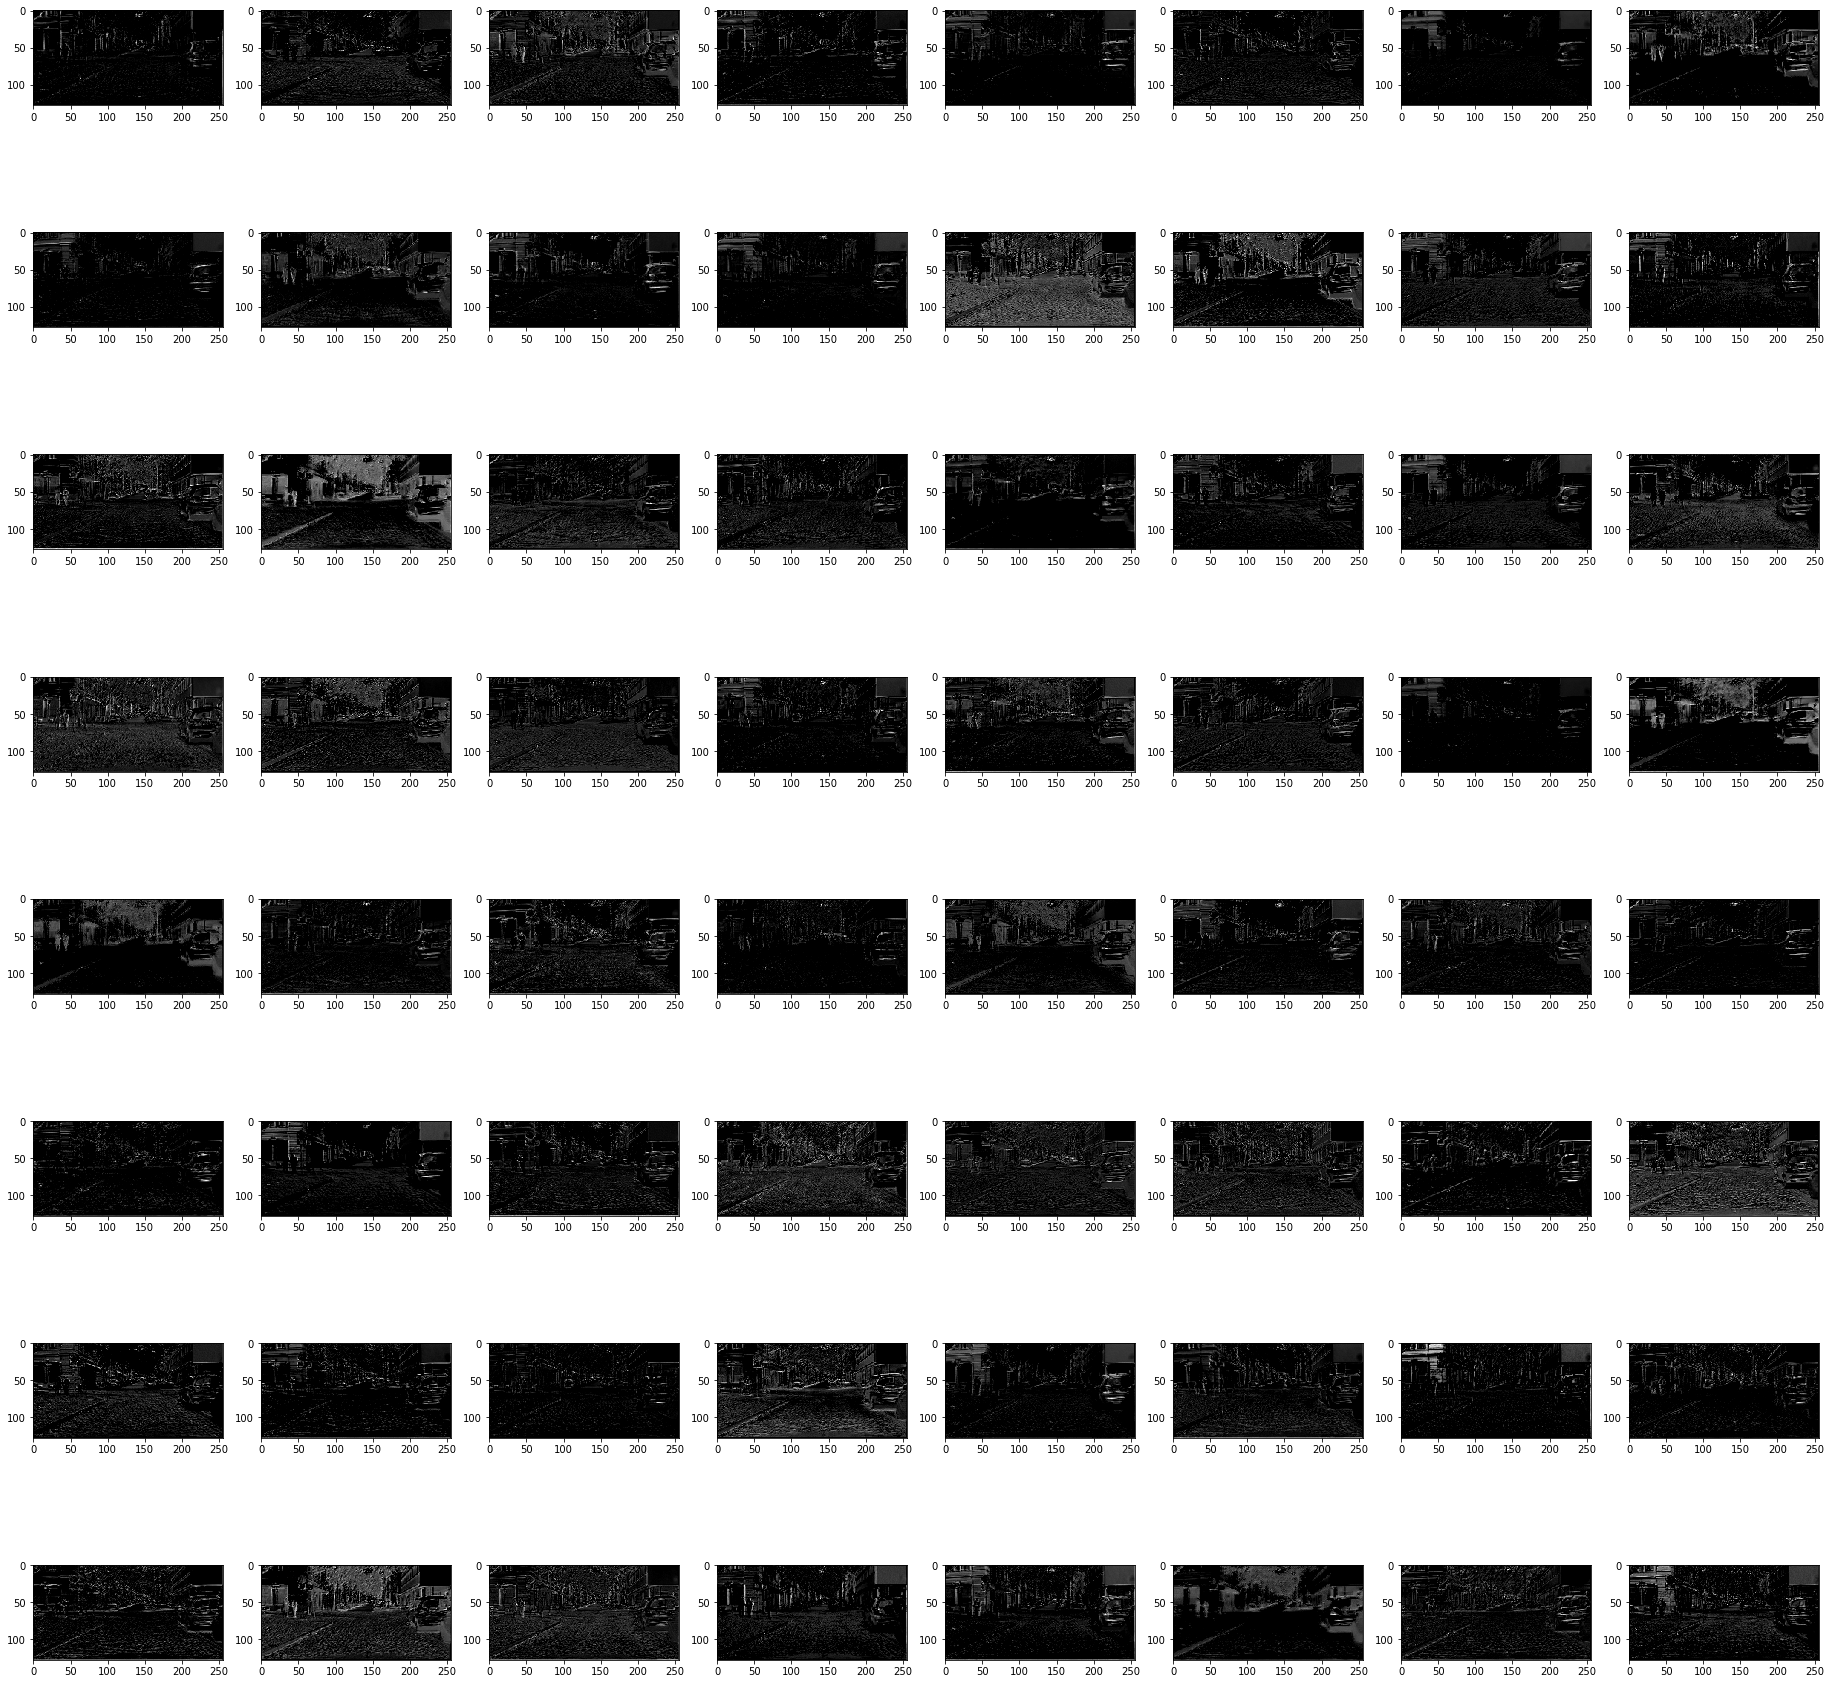

In [20]:
layer_to_visualize(imgBatch, model.k, model.k.get_layer('old_conv_pw_1_relu'), layers)    

('Shape of conv:', (64, 128, 256))
('convs', 64)


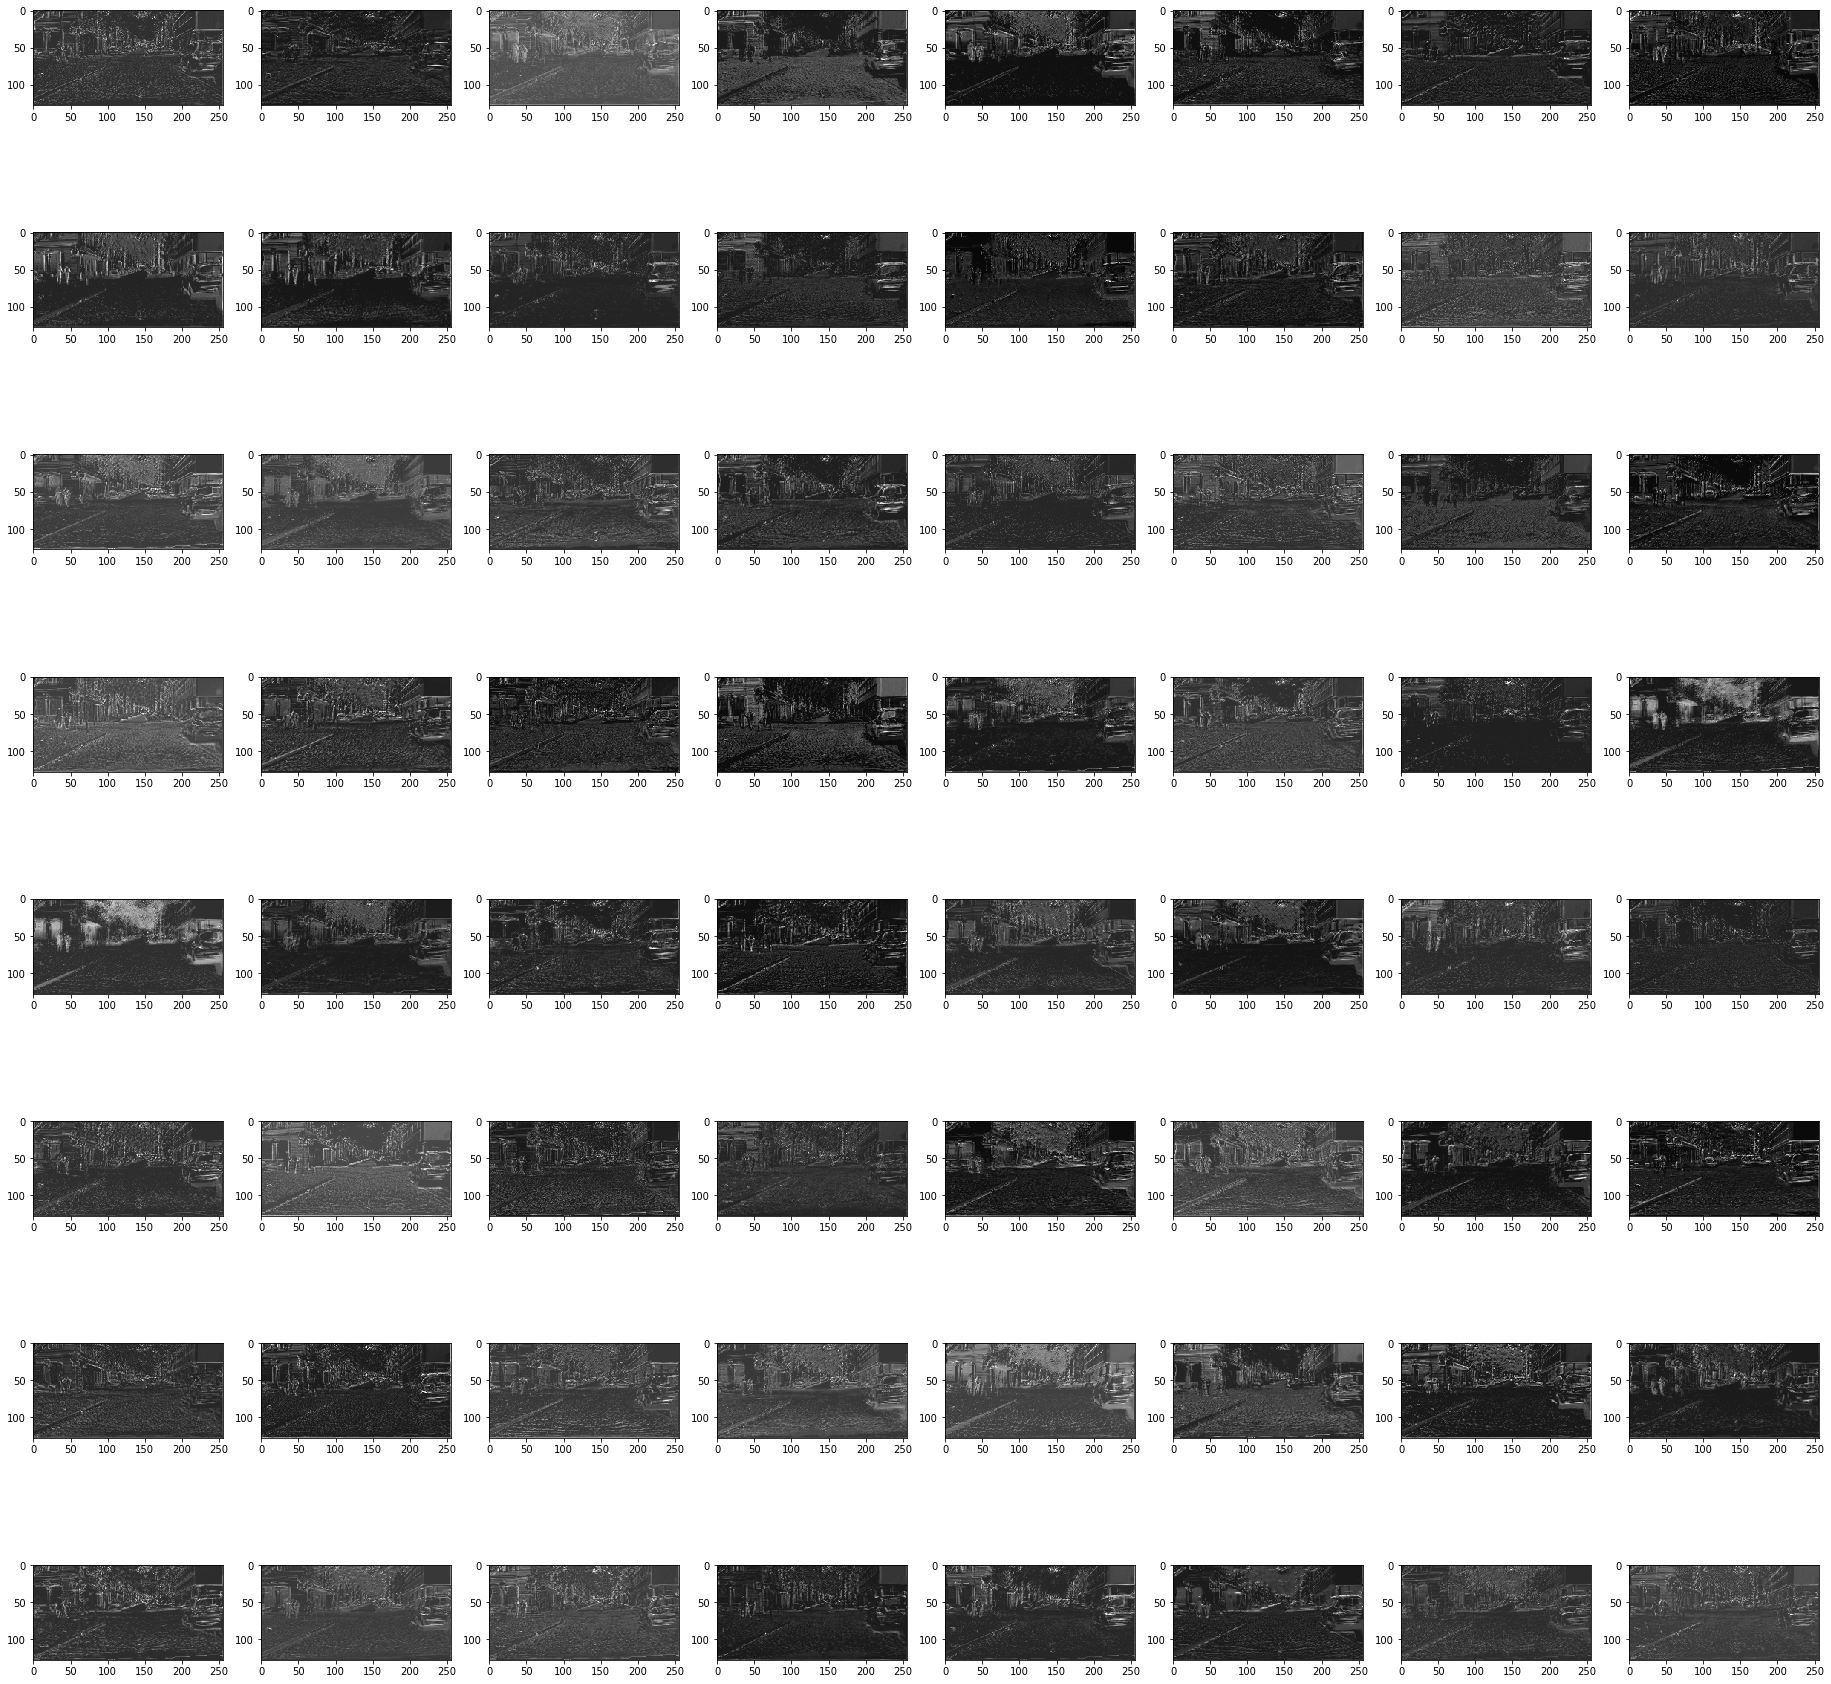

In [21]:
layer_to_visualize(imgBatch, model.k, model.k.get_layer('add_1'), layers)

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_new (InputLayer)           (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 128, 256, 32) 864         data_new[0][0]                   
__________________________________________________________________________________________________
conv_0_bn (BatchNormalization)  (None, 128, 256, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
conv_0_relu (Activation)        (None, 128, 256, 32) 0           conv_0_bn[0][0]                  
__________________________________________________________________________________________________
conv_dw_1 